In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import pylab as pl
from IPython import display

In [2]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class ENCODER(nn.Module):
    def __init__(self):
        super(ENCODER, self).__init__()
        self.block1 = Block(3,64)
        self.block2 = Block(64,64)
        self.block3 = Block(64,64)
        self.block4 = Block(64,64)
        
    def forward(self, inp):
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return out.view(out.size(0),-1)

class smartPREDICTOR(nn.Module):
    def __init__(self):
        super(smartPREDICTOR, self).__init__()
        self.sm = nn.LogSoftmax()
        
    def forward(self, support, stargs, inp, lim):
        model = LogisticRegression(solver='sag',multi_class='multinomial',max_iter=lim)
        model.fit(support.data.cpu().numpy(),stargs.data.cpu().numpy())
        weights = Variable(torch.FloatTensor(model.coef_).transpose(0,1)).cuda()
        probs = self.sm(torch.matmul(inp,weights))
        return probs

In [3]:
trainset = torch.load('mIN_train.pth')
testset = torch.load('mIN_test.pth')
valset = torch.load('mIN_val.pth')

In [4]:
standardize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485,.456,.406],std=[.229,.224,.225])
            ])
alter = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(84,padding=10),
            standardize
            ])

def batchmaker(way,trainshot,testshot,theset,alterful=False):
    classes = np.random.choice(len(theset),way)
    if alterful:
        li = [torch.cat([alter(theset[cl][i]).view(1,3,84,84) for i in 
                         np.random.choice(600,trainshot+testshot)],dim=0).float()
              for cl in classes]
    else:
        li = [torch.cat([standardize(theset[cl][i]).view(1,3,84,84) for i in 
                         np.random.choice(600,trainshot+testshot)],dim=0).float()
              for cl in classes]
    support = torch.cat([t[:trainshot,:,:,:] for t in li],dim=0)
    stargs = torch.LongTensor([i//trainshot for i in range(trainshot*way)])
    query = torch.cat([t[trainshot:,:,:,:] for t in li],dim=0)
    qtargs = torch.LongTensor([i//testshot for i in range(testshot*way)])
#     print(support.size(),query.size())
    return(Variable(support).cuda(),
           Variable(query, volatile=(not alterful)).cuda(),
           Variable(qtargs, volatile=(not alterful)).cuda(),
           Variable(stargs).cuda()
          )
    
def newevaluate(embed,model,criterion,way,trainshot,testshot,theset):
    losstracker = 0
    acctracker = 0
    acclist = []
    for i in range(reps):
#         print(i)
        support, query, qtargs, stargs = batchmaker(way,trainshot,testshot,theset)
        embeds = embed(support)
        qembeds = embed(query)
        preds = model(embeds, stargs, qembeds, 50)

        # Val loss
        loss = criterion(preds,qtargs)
        losstracker += loss.data[0]
        
        # Val accuracy
        _,bins = torch.max(preds,1)
        acc = torch.sum(torch.eq(bins,qtargs)).data[0]/testshot/way
        acctracker += acc
        acclist.append(acc)
#         display.clear_output(wait=False)
        
    return losstracker/reps,acctracker/reps,np.var(acclist)

way = 20
evalway = 5
trainshot = 30
testshot = 5
reps = 50

In [5]:
torch.cuda.set_device(1)
embed = ENCODER().cuda()
model = smartPREDICTOR().cuda()
losstracker,evallosstracker,evalacctracker = [],[],[]
nweights = sum([i.numel() for i in list(embed.parameters())])
print(nweights," parameters in neural net.")

113088  parameters in neural net.


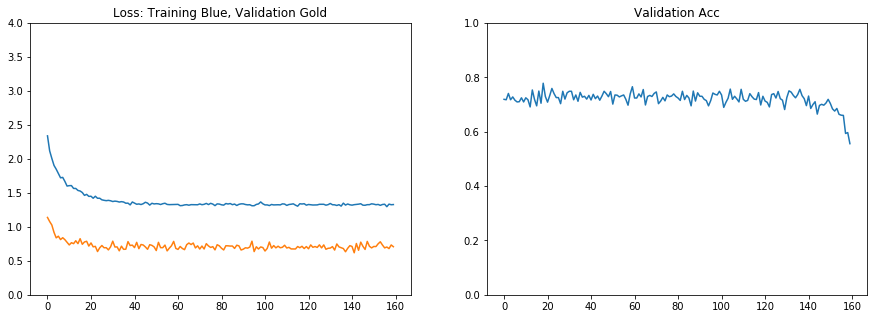

Train loss is: 1.327981718301773
Validation accuracy is: 0.7191999999999998
Validation loss is: 0.7076639455556869



In [6]:
# TRAIN!
criterion = nn.NLLLoss().cuda()
vbity = 250
epoch = 2000

runningloss = 0
te_optimizer = None
for it in range(20*epoch):
    if it%10==0:
        print(it)
    
    # Build batch
    support, query, qtargs, stargs = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    embeds = embed(support)
    qembeds = embed(query)
    preds = model(embeds, stargs, qembeds, int((it/40000)**2)*80+20)

    # Calculate Loss
    loss = criterion(preds, qtargs)
    runningloss += loss.data[0]
    
    # Backprop
    if it%epoch == 0:
        te_optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    loss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    te_optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        evalloss, evalacc, _ = newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset)
        evallosstracker.append(evalloss)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.ylim((0,4))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker[::-1])
        pl.ylim((0,1))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+"\n")
        runningloss = 0

# META
        

In [7]:
name = 'sklearn_highshot'
torch.save((embed,model,losstracker,evallosstracker,evalacctracker),'saved_models/'+name+'.pth')
torch.save(embed.cpu().state_dict(),'saved_models/'+name+'_cpu.pth')

/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ENCODER. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type smartPREDICTOR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [8]:
np.mean(evalacctracker[-1000:])

0.7235450000000001

In [73]:
class PREDICTOR(nn.Module):
    def __init__(self):
        super(PREDICTOR, self).__init__()
        self.sm = nn.LogSoftmax()
        
    def forward(self, support, inp, way):
        assert support.size(0)%way == 0,"Error: classes are not the same size!"
        support = support.view(way,support.size(0)//way,-1)
        centroids = torch.mean(support, 1).view(support.size(0),-1)
#         temp1 = torch.stack([centroids]*inp.size(0))
#         temp2 = torch.stack([inp]*centroids.size(0)).transpose(0,1)
#         print(temp1.size(),temp2.size())
        distmat = torch.sum((torch.stack([centroids]*inp.size(0))-torch.stack([inp]*centroids.size(0))
                             .transpose(0,1))**2,2).squeeze()*-1
        probs = self.sm(distmat)
        return probs
embed, _ = torch.load('saved_models/naive_2_noinfo.pth')
embed = embed.cuda()

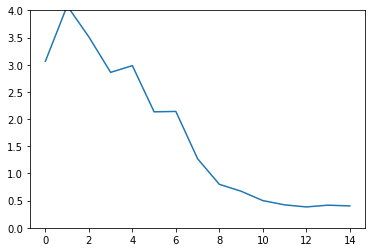

In [30]:
# Build batch
# embed, model, _,_,_ = torch.load('saved_models/smart_1.pth')
support, query, qtargs, stargs = batchmaker(way,trainshot,testshot,valset,alterful=False)
criterion = nn.NLLLoss().cuda()
embed = embed.cuda()
model = model.cuda()

# Predict
tracker = []
embed.zero_grad()
embeds = embed(support)
model.initialize(way)
tr_optimizer = optim.Adam(model.parameters(),lr=.01)
for i in range(15):
    model.zero_grad()
    preds = model(embeds.detach())
    loss = criterion(preds, stargs)
    tracker.append(loss.data[0])
    loss.backward()
    tr_optimizer.step()
# print(model.weights.data)
# print(torch.var(model.weights.data.view(-1)),torch.max(model.weights.data),torch.min(model.weights.data))
pl.figure()
pl.plot(tracker)
pl.ylim((0,4))
pl.show()

In [30]:
torch.mean(torch.norm(embeds,2,1))

Variable containing:
 20.6023
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [ ]:
# BASELINE

In [25]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET

(0.91514739215374, 0.6385333333333335, 0.010876071111111113)


In [13]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,trainset))
# TRAINSET

(0.6446040686964989, 0.7650666666666668, 0.0088703288888888881)


In [13]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 100 PATIENCE, NAIVE

(0.7136507552862167, 0.7288000000000002, 0.012978559999999997)


In [15]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 100 PATIENCE, SMART

(0.726845205873251, 0.7353333333333336, 0.0094271111111111101)


In [ ]:
# EXPERIMENTS

In [71]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 100 PATIENCE, SMART. LR .1, MOM 0

(0.9770350706577301, 0.6170666666666665, 0.010962062222222221)


In [77]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 100 PATIENCE, NAIVE. LR .1, MOM 0

(0.9578658026456833, 0.6214000000000002, 0.013506039999999999)


In [68]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 50 PATIENCE, SMART. LR .1, MOM 0.5

(0.9450288346409798, 0.6406666666666669, 0.013203111111111108)


In [64]:
print(newevaluate(embed,model,criterion,evalway,trainshot,testshot,testset))
# TESTSET, 20 PATIENCE, SMART. LR 1, MOM .5

(0.9806817117333412, 0.6148000000000002, 0.011196071111111108)


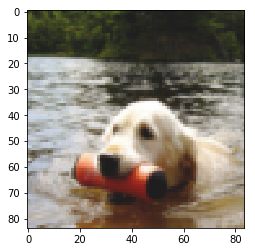

In [132]:
from random import randint
pl.figure()
pl.imshow(testset[randint(0,len(testset)-1)][randint(0,len(testset[0])-1)])
pl.show()

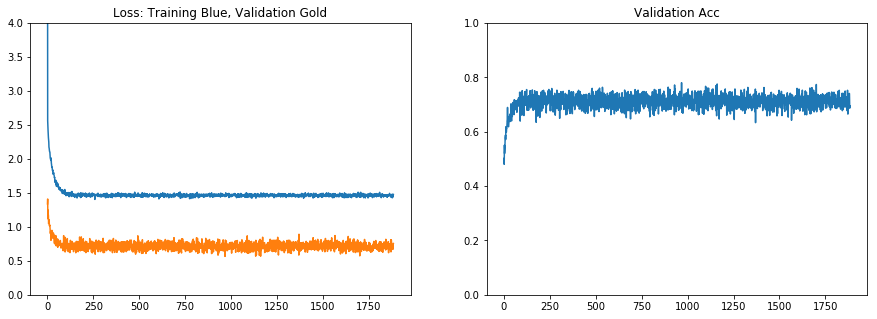

Train loss is: 1.4755005943775177
Validation accuracy is: 0.6951111111111113
Validation loss is: 0.7553736646970113

188500
188510
188520
188530
188540
188550


KeyboardInterrupt: 

In [6]:
# TRAIN!
criterion = nn.NLLLoss().cuda()
vbity = 100
epoch = 2000

losstracker,evallosstracker,evalacctracker = [],[],[]
runningloss = 0
optimizer = None
for it in range(epoch*100):
    if it%10==0:
        print(it)
    
    # Build batch
    support, query, qtargs, _ = batchmaker(way,trainshot,testshot,trainset,alterful=True)
    
    # Predict
    embed.zero_grad()
    model.zero_grad()
    embeds = embed(support)
    qembeds = embed(query)
    preds = model(embeds,qembeds,way)

    # Calculate Loss
    loss = criterion(preds, targs)
    runningloss += loss.data[0]
    
    # Backprop
    if it%epoch == 0:
        optimizer = optim.Adam(embed.parameters(),lr=.001/(2**(it//epoch)))
    loss.backward()
#     nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()
    
    # Report
    if it%vbity == vbity-1:
        display.clear_output(wait=True)

        losstracker.append(runningloss/vbity)
        evalloss, evalacc = evaluate(embed,model,criterion,evalway,trainshot,testshot)
        evallosstracker.append(evalloss)
        evalacctracker.append(evalacc)
        
        pl.figure(1,figsize=(15,5))
        pl.subplot(1,2,1)
        pl.plot(losstracker)
        pl.plot(evallosstracker)
        pl.ylim((0,4))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(1,2,2)
        pl.plot(evalacctracker)
        pl.ylim((0,1))
        pl.title("Validation Acc")
        pl.show()
        
        print("Train loss is: "+str(runningloss/vbity)+
              "\nValidation accuracy is: "+str(evalacc)+
              "\nValidation loss is: "+str(evalloss)+"\n")
        runningloss = 0


In [ ]:
Paper model achieves (over last 1000):
    0.71156711111111126
after 188500 iters

In [213]:
support = supportmaker(nclass,shot)
inp = inpmaker(nclass)
embeds = embed(support)
query = embed(inp)
model(embeds,query)

Variable containing:
-6.7075e-03 -5.0079e+00 -2.7911e+01
-2.9057e+00 -5.6263e-02 -4.5704e+01
-1.8272e+01 -4.3870e+01 -1.1600e-08
[torch.FloatTensor of size 3x3]